<h1>9. Add weather data (reforecasts)

In [86]:
import numpy as np
import pandas as pd
import xarray as xr
import json
import os

# Define lead times
lead_times = list(range(0, 91)) + [93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144]

# Load wind power plant (WPP) data
with open("../data/WPPs+production_new.json", "r", encoding="utf-8") as f:
    wpps = json.load(f)

# Load existing forecast production data (if available)
output_json_file = "forecast_production_data.json"
if os.path.exists(output_json_file):
    print(f"Loading existing data from {output_json_file}")
    with open(output_json_file, "r", encoding="utf-8") as f:
        lead_time_dicts = json.load(f)
else:
    lead_time_dicts = {str(lt): {} for lt in lead_times}  # Initialize empty structure

# Ensure lead times are stored as strings (JSON stores keys as strings)
lead_time_dicts = {str(lt): lead_time_dicts.get(str(lt), {}) for lt in lead_times}

# Track already processed (WPP, year, month) combinations
print("Analysing existing entries")
existing_entries = set()
for lead_time in lead_time_dicts:
    for unique_key in lead_time_dicts[lead_time]:
        # Extract WPP, year, and month from existing data
        existing_dates = [pd.to_datetime(entry[0]) for entry in lead_time_dicts[lead_time][unique_key].get("Production", [])]
        existing_months = {(date.year, date.month) for date in existing_dates}
        existing_entries.update((unique_key, year, month) for year, month in existing_months)

# Forecast file directory
forecast_dir = "reforecast_data"

print("Iterating over WPPs")
# Process each WPP
for index, wpp in enumerate(wpps):
    json_id = wpp["JSON-ID"]
    wpp_id = wpp["ID_The-Wind-Power"]
    unique_key = f"{json_id}_{wpp_id}"  # Unique identifier

    # Convert production timestamps to pandas datetime format
    date_range = pd.to_datetime([entry[0] for entry in wpp["Production"]])
    production_values = [entry[1] for entry in wpp["Production"]]

    # Create a DataFrame for production data
    production_df = pd.DataFrame({"date": date_range, "production": production_values})

    # Extract unique month-year combinations from production timestamps
    unique_months = set(zip(date_range.year, date_range.month))

    for year, month in unique_months:
        grib_file = os.path.join(forecast_dir, f"{index}_{json_id}_{year}_{month:02d}.grib")
        
        print(f"Processing{grib_file}")
        # **Check if this (WPP, year, month) combination is already processed**
        if (unique_key, year, month) in existing_entries:
            print(f"Already in data set --> skipping")
            continue  # Skip this iteration

        # Skip if no forecast file exists
        if not os.path.exists(grib_file):
            print(f"No forecast data --> skipping")
            continue

        # Attempt to load wind speed forecast data
        try:
            ds = xr.open_dataset(grib_file, engine="cfgrib")
        except Exception as e:
            print(f"Error reading {grib_file}: {e} --> skipping")
            continue

        # Compute wind speed from u100 and v100 wind components
        u100 = ds["u100"].values
        v100 = ds["v100"].values
        wind_speeds = np.sqrt(u100**2 + v100**2)

        # Convert forecast times to pandas datetime format
        forecast_times = pd.to_datetime(ds.valid_time.values)

        # Create a DataFrame for wind speed forecasts
        forecast_df = pd.DataFrame({
            "lead_time": np.tile(lead_times, len(forecast_times)),
            "forecast_time": np.concatenate(forecast_times),
            "wind_speed": wind_speeds.flatten()
        })

        # Sort forecasts by forecast_time
        forecast_df = forecast_df.sort_values(by="forecast_time").reset_index(drop=True)

        # Merge production and forecast data based on matching timestamps
        merged_df = pd.merge(production_df, forecast_df, left_on="date", right_on="forecast_time", how="inner")

        # Skip if no matching timestamps found
        if merged_df.empty:
            print(f"No matching data --> skipping")
            continue

        # Store data in structured dictionary grouped by lead time
        for lead_time, group in merged_df.groupby("lead_time"):
            lead_time_str = str(lead_time)  # Ensure keys are strings for JSON compatibility

            # Skip if this WPP & lead time combo is already in the dataset
            if unique_key not in lead_time_dicts[lead_time_str]:
                
                # Initialize new WPP entry
                lead_time_dicts[lead_time_str][unique_key] = {
                    "Name": wpp["Name"],
                    "Names_UK_Plants": wpp["Names_UK_Plants"],
                    "Code": wpp["Code"],
                    "Type": wpp["Type"],
                    "Capacity": wpp["Capacity"],
                    "Continent": wpp["Continent"],
                    "ISO_code": wpp["ISO_code"],
                    "Country": wpp["Country"],
                    "State_code": wpp["State_code"],
                    "Area": wpp["Area"],
                    "City": wpp["City"],
                    "Name_TWP": wpp["Name_TWP"],
                    "Second_name": wpp["Second_name"],
                    "Latitude": wpp["Latitude"],
                    "Longitude": wpp["Longitude"],
                    "Altitude_Depth": wpp["Altitude_Depth"],
                    "Location_accuracy": wpp["Location_accuracy"],
                    "Shore_distance_km": wpp["Shore_distance_km"],
                    "Manufacturer": wpp["Manufacturer"],
                    "Turbine": wpp["Turbine"],
                    "Hub_height": wpp["Hub_height"],
                    "Number_of_turbines": wpp["Number_of_turbines"],
                    "Developer": wpp["Developer"],
                    "Operator": wpp["Operator"],
                    "Owner": wpp["Owner"],
                    "Commissioning_date": wpp["Commissioning_date"],
                    "Status": wpp["Status"],
                    "Decommissioning_date": wpp["Decommissioning_date"],
                    "Source_link": wpp["Source_link"],
                    "Last_update": wpp["Last_update"],
                    "Production": []
                }

            # Append production and wind speed data for this lead time and WPP
            lead_time_dicts[lead_time_str][unique_key]["Production"].extend([
                [str(date), production, wind_speed]
                for date, production, wind_speed in group[["date", "production", "wind_speed"]].values.tolist()
            ])

# Save updated JSON
with open(output_json_file, "w", encoding="utf-8") as f:
    json.dump(lead_time_dicts, f, indent=4)

print(f"Updated JSON file saved: {output_json_file}")


Loaded existing data from forecast_production_data.json
Analysing existing entries
Iterating over WPPs
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-04
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-07
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-10
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-06
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-03
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-09
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2023-12
Already in data set --> skipping
Processing WPP A1 DE PARC EOLIEN EN MER DE LA BAIE DE ST-BRIEUC for 2024-02
Already in data set --> skipping
Processing WPP A1 DE PARC

Plot power over wind speed per plant and lead time

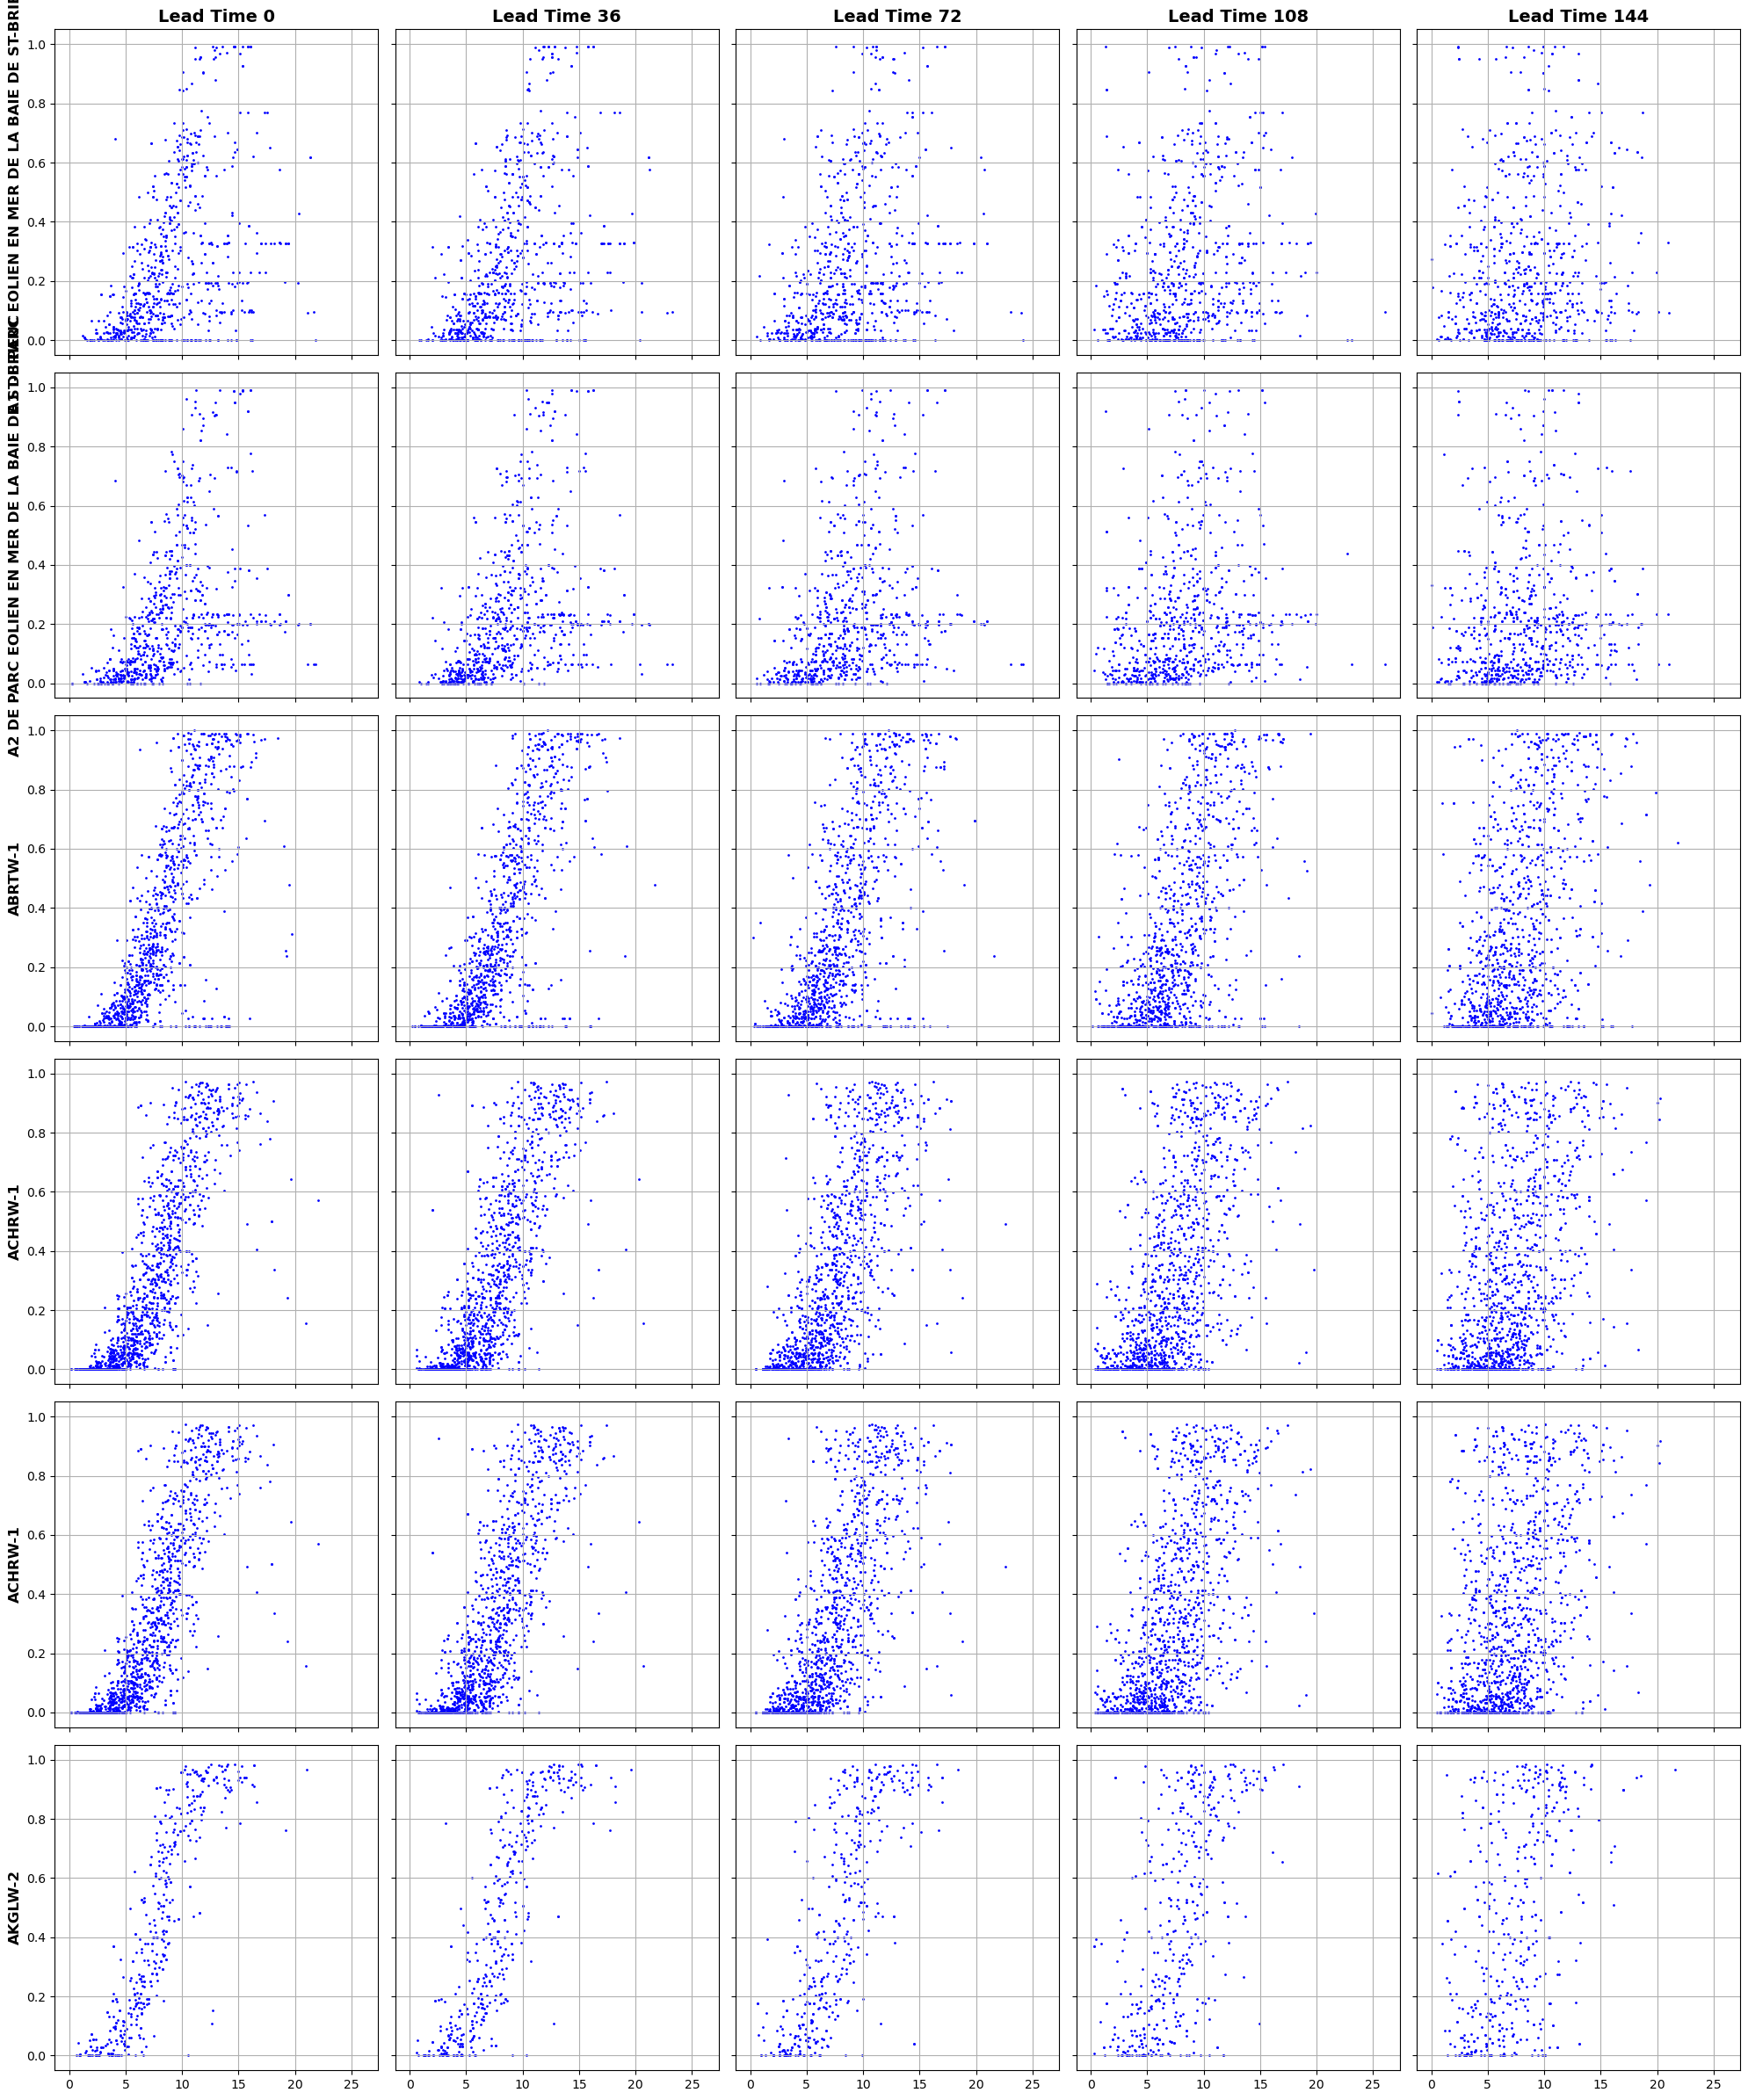

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Define lead times of interest
lead_times = [str(0), str(36), str(72), str(108), str(144)]

# Determine the number of WPPs to plot (smallest number of WPPs across all lead times)
wpp_ids_per_lead_time = {lt: list(lead_time_dicts[lt].keys()) for lt in lead_times}
min_wpps = min(len(wpp_ids) for wpp_ids in wpp_ids_per_lead_time.values() if wpp_ids)

# Create subplots (rows = WPPs, columns = lead times)
fig, axes = plt.subplots(nrows=min_wpps, ncols=len(lead_times), figsize=(20, 4 * min_wpps), sharex=True, sharey=True)

# Set lead time titles at the top
for col_idx, lead_time in enumerate(lead_times):
    axes[0, col_idx].set_title(f"Lead Time {lead_time}", fontsize=14, fontweight='bold')

# Loop through WPPs and lead times
for col_idx, lead_time in enumerate(lead_times):
    for row_idx in range(min_wpps):
        wpp_id = wpp_ids_per_lead_time[lead_time][row_idx]
        wpp_data = lead_time_dicts[lead_time][wpp_id]
        
        # Convert production data to DataFrame
        df = pd.DataFrame(wpp_data["Production"], columns=["date", "production", "wind_speed"])
        
        # Convert columns to proper types
        df["date"] = pd.to_datetime(df["date"])
        df["production"] = df["production"].astype(float)
        df["wind_speed"] = df["wind_speed"].astype(float)
        
        # Normalize production by capacity
        capacity = wpp_data["Capacity"]
        df["normalised_production"] = df["production"] / capacity
        
        # Scatter plot
        ax = axes[row_idx, col_idx] if min_wpps > 1 else axes[col_idx]  # Handle case of one row
        ax.scatter(df["wind_speed"], df["normalised_production"], s=1, c='blue')
        
        # Only label the first column with WPP names
        if col_idx == 0:
            ax.set_ylabel(wpp_data["Name"], fontsize=12, fontweight='bold')

        ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [88]:
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import os

# Load the forecast production data
with open("forecast_production_data.json", "r", encoding="utf-8") as file:
    forecast_data = json.load(file)

# Define lead times
lead_times = list(forecast_data.keys())

# Lists to store models and scalers
models = {}
scalers = {}

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Train an MLP for each lead time
for lead_time in lead_times:
    print(f"Processing lead time: {lead_time}")
    
    all_features = []
    all_targets = []
    turbine_types = []
    hub_heights = []
    capacities = []
    ages = []
    
    for unique_key, wpp in forecast_data[lead_time].items():
        turbine_types.append(wpp["Turbine"])
        hub_heights.append(wpp["Hub_height"] if wpp["Hub_height"] else 100)
        capacities.append(wpp["Capacity"])
        commissioning_date = wpp["Commissioning_date"] if wpp["Commissioning_date"] else "2015/06"
        ages.append(2024 - int(commissioning_date.split("/")[0]))
        
        for entry in wpp["Production"]:
            timestamp, production, wind_speed = entry
            all_features.append([wind_speed])
            all_targets.append(production / wpp["Capacity"])
    
    # Convert lists to numpy arrays
    all_features = np.array(all_features)
    all_targets = np.array(all_targets).reshape(-1, 1)
    
    # One-Hot Encode turbine types
    encoder = OneHotEncoder(sparse_output=False)
    turbine_types_onehot = encoder.fit_transform(np.array(turbine_types).reshape(-1, 1))
    
    # Normalize numerical features
    scaler_hub = StandardScaler()
    scaler_age = StandardScaler()
    scaler_wind = StandardScaler()
    
    hub_heights_scaled = scaler_hub.fit_transform(np.array(hub_heights).reshape(-1, 1))
    ages_scaled = scaler_age.fit_transform(np.array(ages).reshape(-1, 1))
    wind_speeds_scaled = scaler_wind.fit_transform(all_features)
    
    # Combine features
    combined_features = np.hstack((turbine_types_onehot, hub_heights_scaled, ages_scaled, wind_speeds_scaled))
    
    # Convert to PyTorch Dataset
    dataset = WindPowerDataset(combined_features, all_targets)
    
    # Train-test split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Model setup
    input_size = combined_features.shape[1]
    model = MLP(input_size)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    for epoch in range(10):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Lead Time {lead_time} - Epoch {epoch+1}: Loss = {epoch_loss/len(train_loader):.4f}")
    
    # Save model
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), f"models/model_lead_time_{lead_time}.pth")
    
    # Save scalers
    scalers[lead_time] = {
        "turbine_encoder": encoder,
        "hub_scaler": scaler_hub,
        "age_scaler": scaler_age,
        "wind_scaler": scaler_wind,
    }
    
# Save all scalers
joblib.dump(scalers, "models/scalers.pkl")
print("All models and scalers saved successfully.")



KeyboardInterrupt: 